In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/edu-data")
!ls

df_video_with_country_nonan.csv     stem_video_titles_tags_30percent.xlsx
final_keywords.txt		    stem_video_titles_tags_50.xlsx
is_stem_column_0.csv		    video_with_channelcountry.csv
is_stem_column_30percent.csv	    video_with_channelcountry.csv.zip
keyword_counts.txt		    video_with_country_and_stem.csv
__MACOSX			    video_with_stem_cutoffs.csv
no_econ_no_game_final_keywords.txt  video_with_stem_cutoffs_post0.csv
stem_video_titles_tags_0.xlsx	    video_with_stem_titles.csv


In [3]:
# Install required packages
! pip3 install polars rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt
from rapidfuzz import fuzz, process
from tqdm import tqdm
import polars as pl
from concurrent.futures import ThreadPoolExecutor
import numpy as np

This time we set a higher fuzzy matching threshold (90%) and no tag match ratio (i.e only need 1 tag matched to keyword list).

In [5]:
# Function to extract unique keywords from a file
def extract_keywords(filepath):
    """
    Extracts unique keywords from a file with the format "x_keywords: [...]".
    """
    keywords = {}
    with open(filepath, 'r') as file:
        for line in file:
            match = re.match(r"(\w+_keywords)\s*=\s*\[(.*?)\]", line, re.DOTALL)
            if match:
                category = match.group(1)
                keyword_str = match.group(2)
                # Handle both single and double quotes, special characters, and filter empty strings
                keyword_list = [''.join(k).strip().strip("'").strip('"').strip("’") for k in re.findall(r"'([^']*)'|[\"]([^\"]*)[\"]|’([^’]*)’", keyword_str)]
                keyword_list = [keyword for keyword in keyword_list if keyword]
                keywords[category] = keyword_list

    # Flatten the dictionary and remove duplicates
    all_keywords = []
    for category, wordlist in keywords.items():
        all_keywords.extend(wordlist)

    return list(set(all_keywords))

def preprocess(text):
    return re.sub(r'[^a-z0-9 ]', '', text.lower().strip())

stem_keywords = extract_keywords('/content/drive/MyDrive/edu-data/final_keywords.txt')
stem_keywords_lower = [preprocess(keyword) for keyword in stem_keywords]
len(stem_keywords)

1985

In [6]:
# Load video data with country field using Polars
df_video_with_country = pl.read_csv('/content/drive/MyDrive/edu-data/video_with_channelcountry.csv')
df_video_with_country = df_video_with_country.filter(pl.col("country").is_not_null())

In [ ]:
# -----------------------------
# Function for fuzzy matching on titles
# -----------------------------
def is_stem_title(title_batch, keywords, score_cutoff=65):
    results = []
    for title in title_batch:
        if title is None or title.strip() == "":
            results.append(False)
            continue

        # Preprocess the title
        title_lower = title.lower().strip()

        # Perform batch fuzzy matching using cdist
        scores = process.cdist([title_lower], keywords, scorer=fuzz.ratio, score_cutoff=score_cutoff)
        match_found = np.any(scores > 0)
        results.append(match_found)
    return results

# -----------------------------
# Function for fuzzy matching on tags with cutoff ratios
# -----------------------------
def count_tags_and_evaluate_cutoffs(tags, cutoffs, keywords, score_cutoff=90):
    if tags is None or tags.strip() == "":
        return [False] * len(cutoffs)

    # Preprocess tags: lowercase and split by commas
    video_tags = [tag.strip() for tag in tags.lower().split(",")]
    total_tags = len(video_tags)

    # Perform batch fuzzy matching using cdist
    scores = process.cdist(video_tags, keywords, scorer=fuzz.ratio, score_cutoff=score_cutoff)
    matched_tags = np.sum(scores > 0)  # Count matches where the score is greater than 0

    # Check if matched tags exceed each cutoff
    return [(matched_tags / total_tags) > cutoff for cutoff in cutoffs]

# Cutoff ratios to test
cutoff_ratios = [0.05, 0.10, 0.15, 0.20]
cutoff_columns = [f'is_stem_cutoff_{int(cutoff * 100)}' for cutoff in cutoff_ratios]

In [11]:
# Function to check if a title has at least one fuzzy match using cdist
def is_stem_title(title_batch, keywords, score_cutoff=65):
    results = []
    for title in title_batch:
        if title is None or title.strip() == "":
            results.append(False)
            continue

        title_lower = preprocess(title)

        # Perform batch fuzzy matching using cdist
        scores = process.cdist([title_lower], keywords, scorer=fuzz.ratio, score_cutoff=score_cutoff)
        match_found = np.any(scores > 0)  # Check if any match exceeds the score cutoff
        results.append(match_found)
    return results

# Process data in parallel with tqdm progress tracking
chunk_size = 1000  # Adjust chunk size based on memory capacity
num_chunks = (len(df_video_with_country) + chunk_size - 1) // chunk_size
results = []

with ThreadPoolExecutor() as executor:
    futures = []
    for i in range(num_chunks):
        chunk = df_video_with_country["title"][i * chunk_size : (i + 1) * chunk_size]
        futures.append(executor.submit(is_stem_title, chunk, stem_keywords_lower))

    for future in tqdm(futures, desc="Evaluating STEM Titles"):
        results.extend(future.result())

# Add the results as a new column to the DataFrame
df_video_with_country = df_video_with_country.with_columns(
    pl.Series("is_stem_title", results)
)

# Save the resulting DataFrame
df_video_with_country.write_csv("/content/drive/MyDrive/edu-data/video_with_stem_titles.csv")

Evaluating STEM Titles: 100%|██████████| 1912/1912 [07:35<00:00,  4.20it/s]


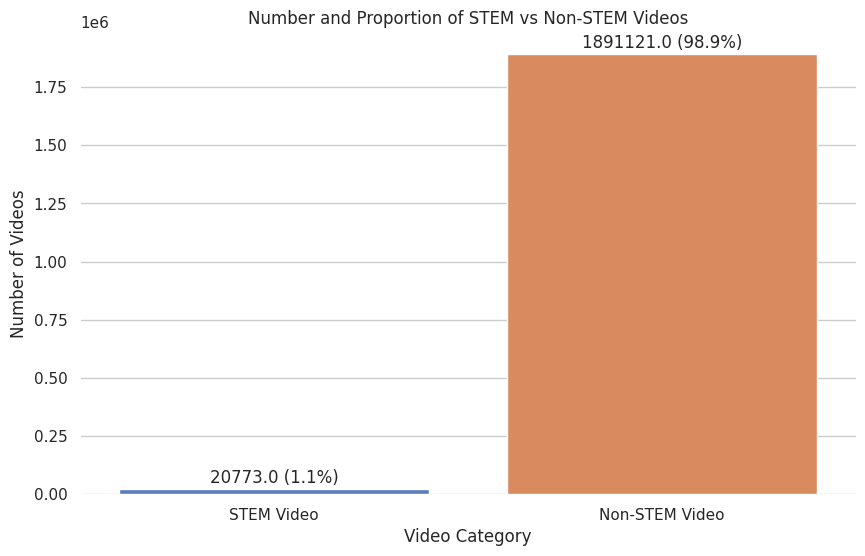

In [7]:
import seaborn as sns

# Load the processed DataFrame
df_video_with_stem_titles = pl.read_csv("/content/drive/MyDrive/edu-data/video_with_stem_titles.csv")

# Count the number of STEM and non-STEM videos
stem_counts = df_video_with_stem_titles["is_stem_title"].value_counts().to_pandas()
stem_counts.columns = ["is_stem_title", "count"]

# Replace True/False with labels for better readability
stem_counts["is_stem_title"] = stem_counts["is_stem_title"].replace({True: "STEM Video", False: "Non-STEM Video"})

# Calculate proportions
total_videos = stem_counts["count"].sum()
stem_counts["proportion"] = stem_counts["count"] / total_videos

# Plot the data
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", palette="muted")

# Create a bar plot
ax = sns.barplot(
    x="is_stem_title",
    y="count",
    data=stem_counts,
    hue="is_stem_title",
    dodge=False,
    legend=False
)

# Add annotations on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height()/total_videos:.1%})',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 8), textcoords='offset points')

# Customize plot appearance
plt.title("Number and Proportion of STEM vs Non-STEM Videos")
plt.xlabel("Video Category")
plt.ylabel("Number of Videos")
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

In [13]:
# Filter rows where 'is_stem_title' is True
stem_videos = df_video_with_stem_titles.filter(pl.col("is_stem_title") == True)

# Randomly sample 100 STEM videos (or fewer if less than 100 are available)
sampled_stem_videos = stem_videos.sample(n=min(100, len(stem_videos)), seed=42)

# Print titles and tags
for row in sampled_stem_videos.iter_rows(named=True):
    print(f"Title: {row['title']}")
    print(f"Tags: {row['tags']}")
    print("-" * 20)

Title: Yacht Cleaning Demonstration
Tags: Carpet,CarpetCleaning,Professional,RobAllen,entrepreneur,Business,CleaningProducts,Education,Groutmaster,BioPro,Unchained,Information,Truckmountforums,Motivation,interlink,Interlinksupply,jondon,yacht,yacht cleaning,RSF
--------------------
Title: Recursos educativos abiertos.
Tags: universidad,politécnica,madrid,upm,españa,politecnica,ingenieria,educacion,ciencia,docencia,videos,educativos,clases,seminarios,innovacion,ingeniería,cursos online,recursos educativos abiertos. REA,telecomunicación,aprendizaje experiencial,innovación educativa,Universidad Politécnica de Madrid,UPM
--------------------
Title: TDME C L5A First Law of Thermodynamics
Tags: None
--------------------
Title: Counting catalan numbers
Tags: None
--------------------
Title: Homogeneous Second Order Linear Differential Equations
Tags: math,differential,equations,Homogeneous,Second,Order,Linear,Differential,Equations,justmathtutoring.com,example
--------------------
Title: "Adv

In [15]:
# Cutoff ratios to test
cutoff_ratios = [0.05, 0.10, 0.15, 0.20]
cutoff_columns = [f'is_stem_cutoff_{int(cutoff * 100)}' for cutoff in cutoff_ratios]

chunk_size = 1000
num_chunks = (len(df_video_with_country) + chunk_size - 1) // chunk_size

def count_tags_and_evaluate_cutoffs(tags, cutoffs, keywords, score_cutoff=90):
    if tags is None or tags.strip() == "":
        return [False] * len(cutoffs)

    # Preprocess tags: lowercase and split by commas
    video_tags = [tag.strip() for tag in tags.lower().split(",")]
    total_tags = len(video_tags)

    # Perform batch fuzzy matching using cdist
    scores = process.cdist(video_tags, keywords, scorer=fuzz.ratio, score_cutoff=score_cutoff)
    matched_tags = np.sum(scores > 0)  # Count matches where the score is greater than 0

    # Check if matched tags exceed each cutoff
    return [(matched_tags / total_tags) > cutoff for cutoff in cutoffs]

tag_results = []

with ThreadPoolExecutor() as executor:
    futures = []
    for i in range(num_chunks):
        chunk = df_video_with_country["tags"][i * chunk_size : (i + 1) * chunk_size]
        futures.append(executor.submit(lambda ch: [count_tags_and_evaluate_cutoffs(tags, cutoff_ratios, stem_keywords_lower) for tags in ch], chunk))

    for future in tqdm(futures, desc="Evaluating STEM Tags with Cutoffs"):
        tag_results.extend(future.result())

# Convert the tag results to a DataFrame with cutoff columns
cutoff_results_df = pl.DataFrame(tag_results, schema=cutoff_columns)

# Combine the results with the original DataFrame
df_video_with_stem_titles_and_tags = df_video_with_stem_titles.hstack(cutoff_results_df)
df_video_with_stem_titles_and_tags.write_csv("/content/drive/MyDrive/edu-data/video_with_stem_titles_and_cutoffs.csv")

Evaluating STEM Tags with Cutoffs: 100%|██████████| 1912/1912 [19:21<00:00,  1.65it/s]
/usr/lib/python3.10/functools.py:889: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  return dispatch(args[0].__class__)(*args, **kw)


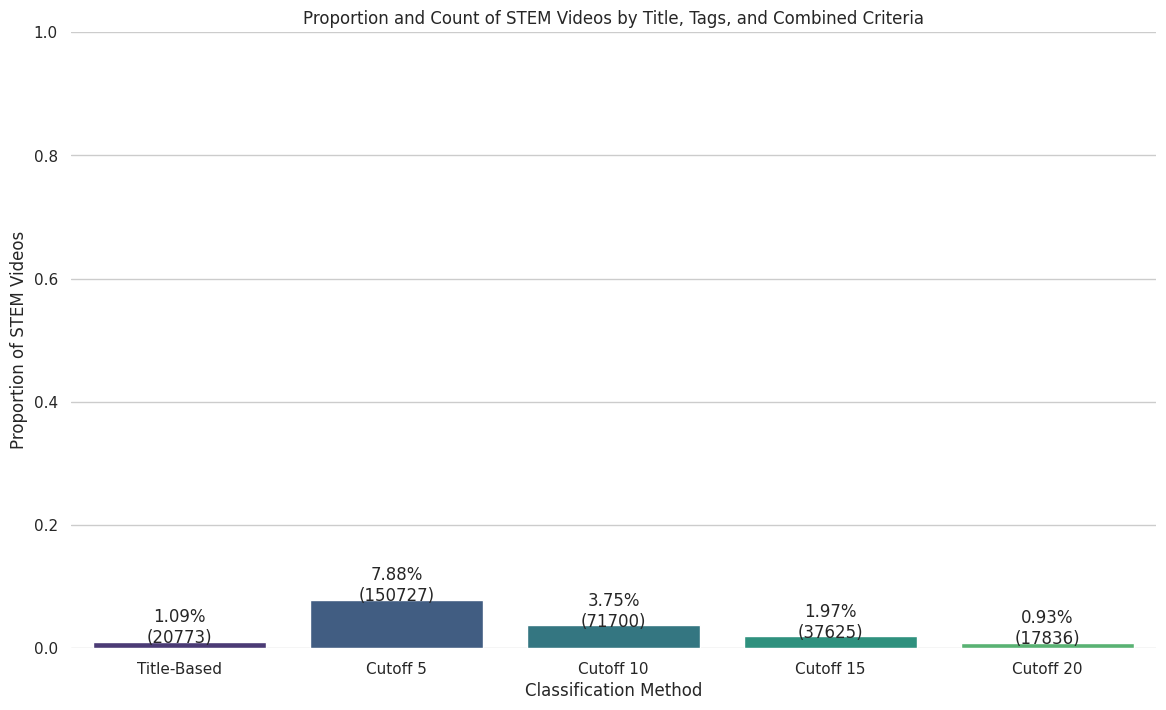

In [20]:
# Load the processed DataFrame
df_video_with_stem_titles_tags = pl.read_csv("/content/drive/MyDrive/edu-data/video_with_stem_titles_and_cutoffs.csv")

# List of tag-based cutoff columns and the combined column
cutoff_columns = ["is_stem_cutoff_5", "is_stem_cutoff_10", "is_stem_cutoff_15", "is_stem_cutoff_20"]

# Calculate counts for tag-based STEM classifications
tag_stem_counts = {col: df_video_with_stem_titles_tags[col].sum() for col in cutoff_columns}

# Calculate the count for title-based STEM classification
title_stem_count = df_video_with_stem_titles_tags["is_stem_title"].sum()

# Convert counts to proportions
total_videos = len(df_video_with_country)
tag_stem_proportions = {key: count / total_videos for key, count in tag_stem_counts.items()}
title_stem_proportion = title_stem_count / total_videos

# Prepare data for plotting
plot_data = pd.DataFrame({
    "Category": ["Title-Based"] + [col.replace("is_stem_", "").replace("_", " ").title() for col in cutoff_columns],
    "Count": [title_stem_count] + list(tag_stem_counts.values()),
    "Proportion": [title_stem_proportion] + list(tag_stem_proportions.values())
})

# Plot the data
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", palette="viridis")

# Create a bar plot
ax = sns.barplot(
    x="Category",
    y="Proportion",
    data=plot_data,
    hue="Category",
    dodge=False,
    legend=False
)

# Add annotations on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}\n({int(p.get_height() * total_videos)})',
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Customize plot appearance
plt.title("Proportion and Count of STEM Videos by Title, Tags, and Combined Criteria")
plt.xlabel("Classification Method")
plt.ylabel("Proportion of STEM Videos")
plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
sns.despine(left=True, bottom=True)

# Show the plot
plt.show()

In [21]:
# Sampling a random set of 100 STEM videos that have titles that pass the 0 thresholding with 65 fuzzy score cutoff
stem_videos = df_video_with_stem_titles_tags.filter(pl.col("is_stem_title") == True)

sampled_stem_videos = stem_videos.sample(n=min(100, len(stem_videos)), seed=42)

for row in sampled_stem_videos.iter_rows(named=True):
    print(f"Title: {row['title']}")
    print(f"Tags: {row['tags']}")
    print("-" * 20)

Title: Yacht Cleaning Demonstration
Tags: Carpet,CarpetCleaning,Professional,RobAllen,entrepreneur,Business,CleaningProducts,Education,Groutmaster,BioPro,Unchained,Information,Truckmountforums,Motivation,interlink,Interlinksupply,jondon,yacht,yacht cleaning,RSF
--------------------
Title: Recursos educativos abiertos.
Tags: universidad,politécnica,madrid,upm,españa,politecnica,ingenieria,educacion,ciencia,docencia,videos,educativos,clases,seminarios,innovacion,ingeniería,cursos online,recursos educativos abiertos. REA,telecomunicación,aprendizaje experiencial,innovación educativa,Universidad Politécnica de Madrid,UPM
--------------------
Title: TDME C L5A First Law of Thermodynamics
Tags: None
--------------------
Title: Counting catalan numbers
Tags: None
--------------------
Title: Homogeneous Second Order Linear Differential Equations
Tags: math,differential,equations,Homogeneous,Second,Order,Linear,Differential,Equations,justmathtutoring.com,example
--------------------
Title: "Adv

In [22]:
# Sampling a random set of 100 STEM videos that pass the 5% threshold
stem_videos = df_video_with_stem_titles_tags.filter(pl.col("is_stem_cutoff_5") == True)

sampled_stem_videos = stem_videos.sample(n=min(100, len(stem_videos)), seed=42)

for row in sampled_stem_videos.iter_rows(named=True):
    print(f"Title: {row['title']}")
    print(f"Tags: {row['tags']}")
    print("-" * 20)

Title: Laboratorio de Experimentación Química
Tags: universidad,politécnica,madrid,upm,españa,politecnica,ingenieria,educacion,ciencia,docencia,videos,educativos,clases,seminarios,innovacion
--------------------
Title: Various Extracts, 1910's - Film 2288
Tags: film,footage,archive,material,history,historical,Interview
--------------------
Title: Driving 2600 Miles for a Job VLOG | California to Florida
Tags: CodingTutorials360,coding,tutorials,360,JavaScript,Walkthrough,Guide,web,development,Driving 2600 Miles for a Job VLOG,Driving 2600 Miles for a Job VLOG | California to Florida,crosss country drive,california to florida,cross country
--------------------
Title: Graphing Inverse Functions
Tags: graphing inverse functions,how to graph inverse functions,inverse functions,precalculus,functions,practice problems,examples,problems
--------------------
Title: CINE-RENDER SURFACES - BASIC
Tags: ArchiCAD (Software),Architecture (Industry),Architect (Profession),Interior Design (Industry),p

In [23]:
# Sampling a random set of 100 STEM videos that pass the 10% threshold
stem_videos = df_video_with_stem_titles_tags.filter(pl.col("is_stem_cutoff_10") == True)

sampled_stem_videos = stem_videos.sample(n=min(100, len(stem_videos)), seed=42)

for row in sampled_stem_videos.iter_rows(named=True):
    print(f"Title: {row['title']}")
    print(f"Tags: {row['tags']}")
    print("-" * 20)

Title: Stephen C. Meyer: Theistic Evolution
Tags: Biola University,Biola,Theistic,Evolution,Darwin,Science,Meyer
--------------------
Title: SFCM 12/13 12: PANTALLAS DE CRISTAL LÍQUIDO
Tags: universidad,politécnica,madrid,upm,españa,politecnica,ingenieria,educacion,ciencia,docencia,videos,educativos,clases,seminarios,innovacion
--------------------
Title: Daily Active Users (as a key performance indicator)
Tags: daily active users,monthly active users,metric,kpi,key performance indicator,finance,accounting
--------------------
Title: West Indian Sugar, 1951 - Film 94332
Tags: film,footage,archive,material,history,historical,Sugar (Ingredient)
--------------------
Title: Phototropism  | Plant Biology | Khan Academy
Tags: education,online learning,learning,lessons
--------------------
Title: Transferencia de ficheros (Linux y MAC OS X vía SCP)
Tags: politécnica,clases,ciencia,educacion,upm,docencia,ingenieria,videos,educativos,CESVIMA HPC VIDEOTUTORIALES . hpc,madrid,politecnica,cesvima,